# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
# sir uncomment it to download
# !wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/exchange_rate.txt.gz -P /content/drive/MyDrive/data/varsity/

In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/exchange_rate.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7588 non-null   float64
 1   1       7588 non-null   float64
 2   2       7588 non-null   float64
 3   3       7588 non-null   float64
 4   4       7588 non-null   float64
 5   5       7588 non-null   float64
 6   6       7588 non-null   float64
 7   7       7588 non-null   float64
dtypes: float64(8)
memory usage: 474.4 KB


In [ ]:
df.head()

,0,1,2,3,4,5,6,7
0,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
2,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
3,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
4,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


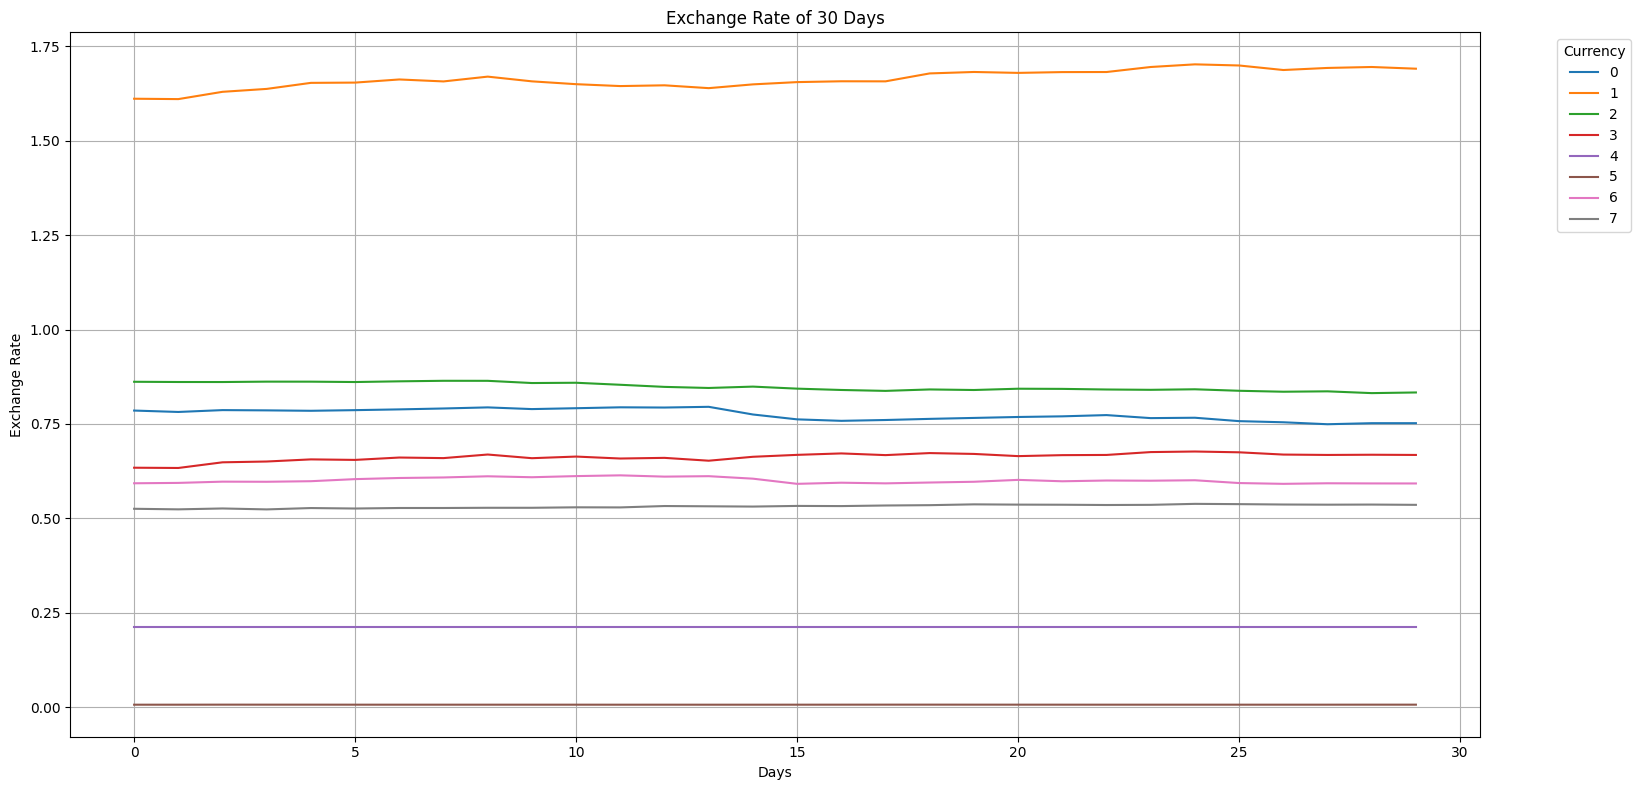

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:30])  # first 30 days, all exchange rates
plt.title('Exchange Rate of 30 Days')
plt.xlabel('Days')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.tight_layout()

# Use dataframe column names as legend labels
plt.legend(df.columns, title="Currency", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


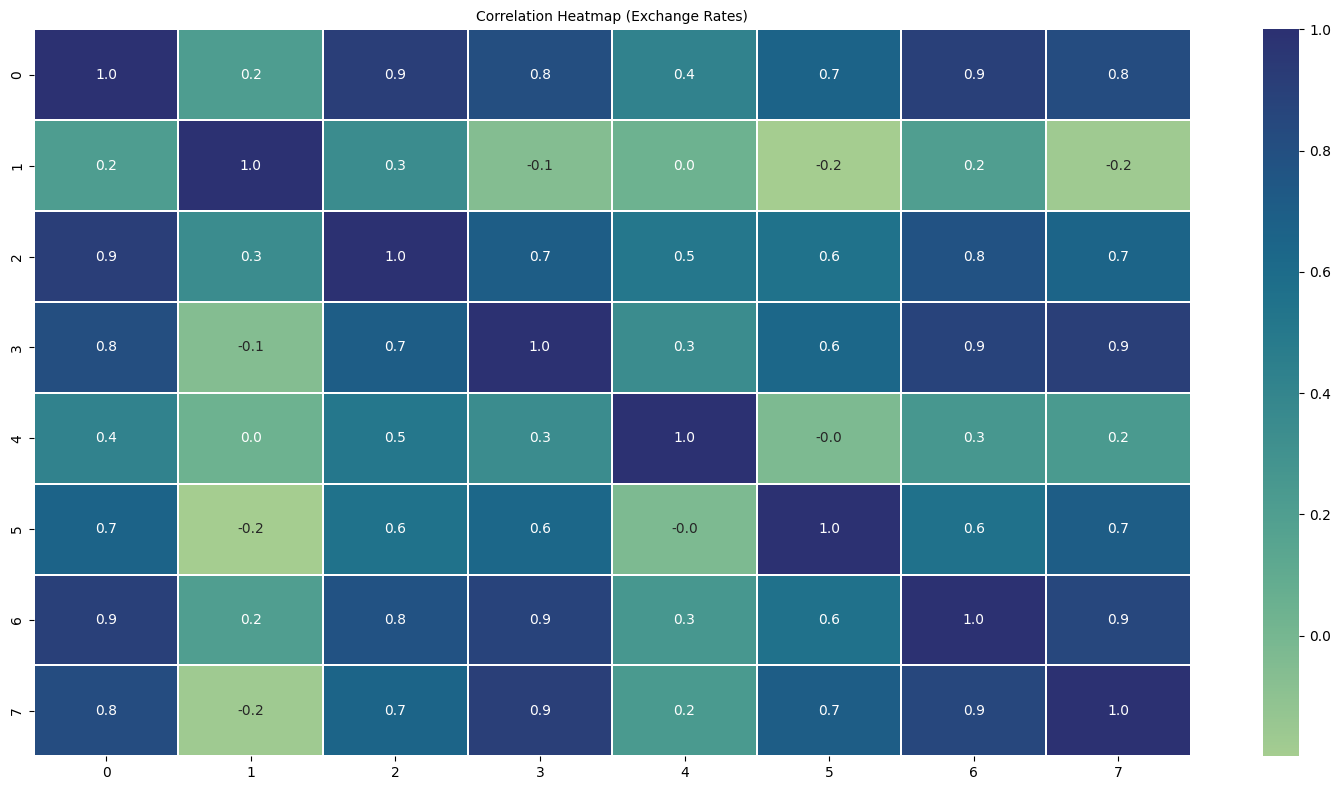

In [ ]:
correlation_subset = df.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='crest', linewidths=0.2, fmt='.1f')

plt.title('Correlation Heatmap (Exchange Rates)', fontsize=10)
plt.tight_layout()
plt.show()


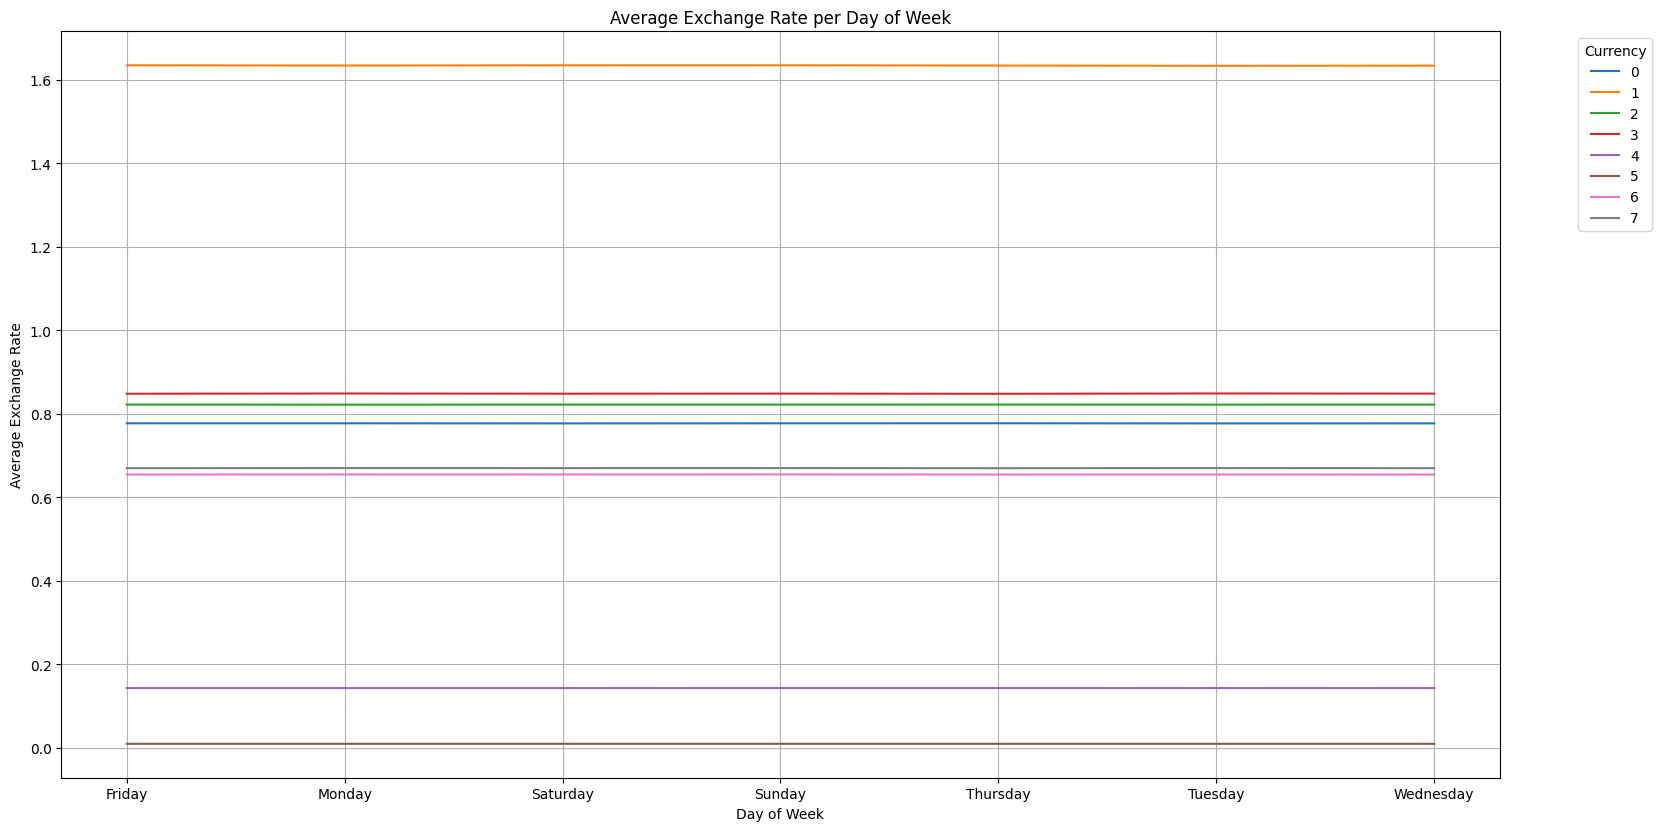

In [ ]:
# Suppose your df index is datetime or just 0..N-1
# Add a day-of-week column if index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    # create dummy datetime index assuming consecutive days
    df.index = pd.date_range(start='2025-01-01', periods=len(df), freq='D')

df['day_of_week'] = df.index.day_name()  # Monday, Tuesday, etc.

# Plot average exchange rate per day of week for all currencies
plt.figure(figsize=(15, 8))
mean_rates = df.groupby('day_of_week').mean()  # mean exchange rate per currency

plt.plot(mean_rates)
plt.grid(True)
plt.tight_layout()
plt.xlabel('Day of Week')
plt.ylabel('Average Exchange Rate')
plt.title('Average Exchange Rate per Day of Week')
plt.legend(df.columns, title='Currency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


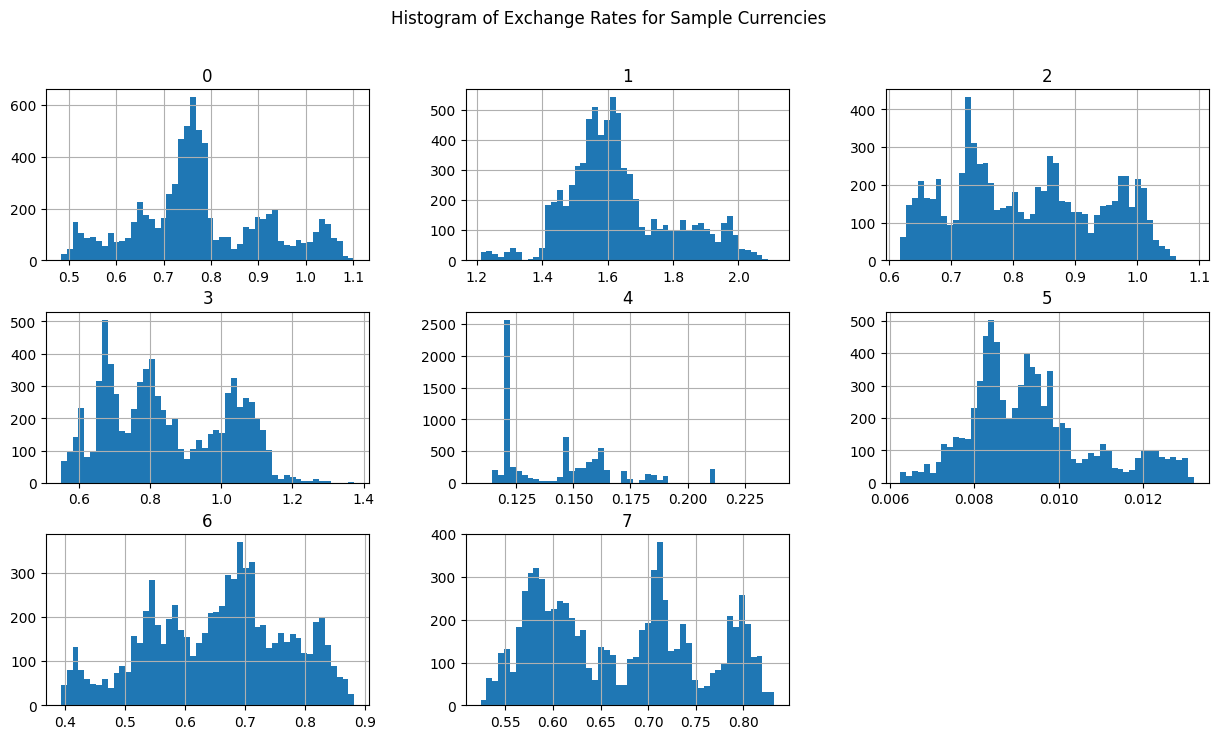

In [ ]:
sample_currencies = df.columns[:]

# Histogram for these currencies
df[sample_currencies].hist(bins=50, figsize=(15,8))
plt.suptitle('Histogram of Exchange Rates for Sample Currencies')
plt.show()

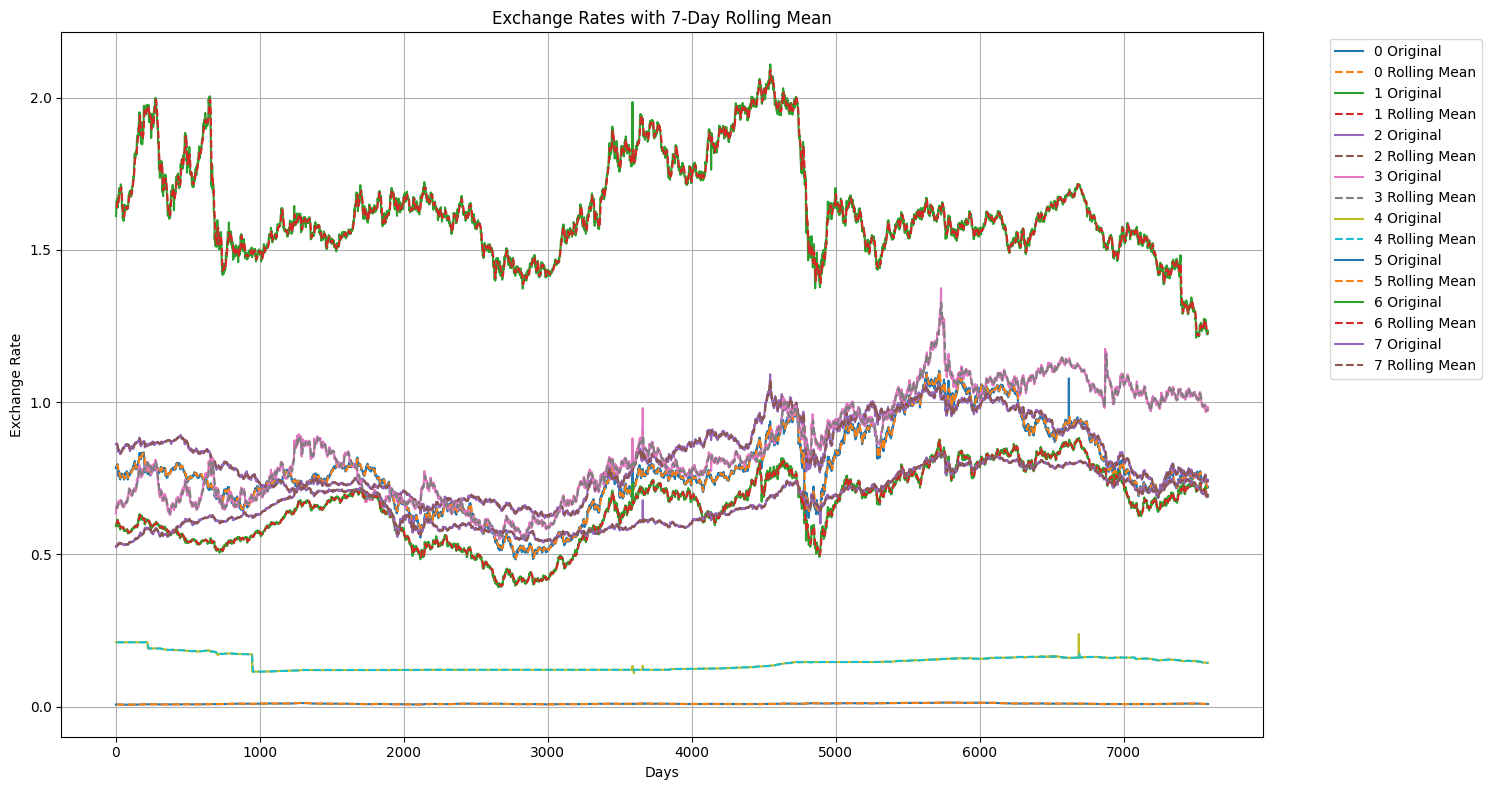

Seasonal decomposition for 0


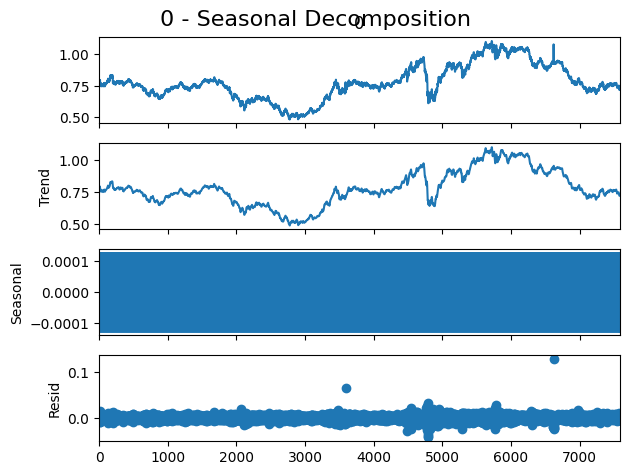

Seasonal decomposition for 1


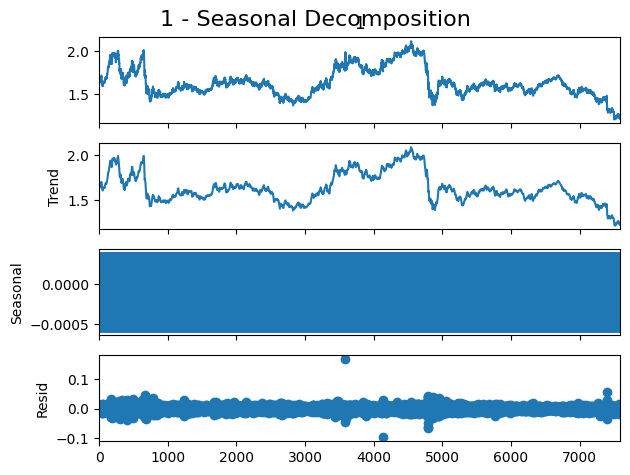

Seasonal decomposition for 2


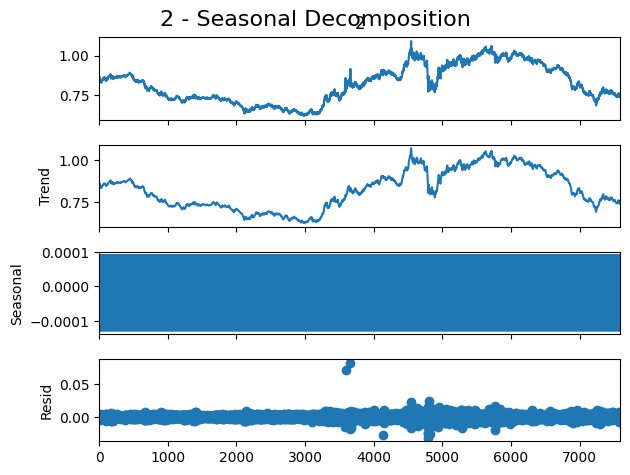

Seasonal decomposition for 3


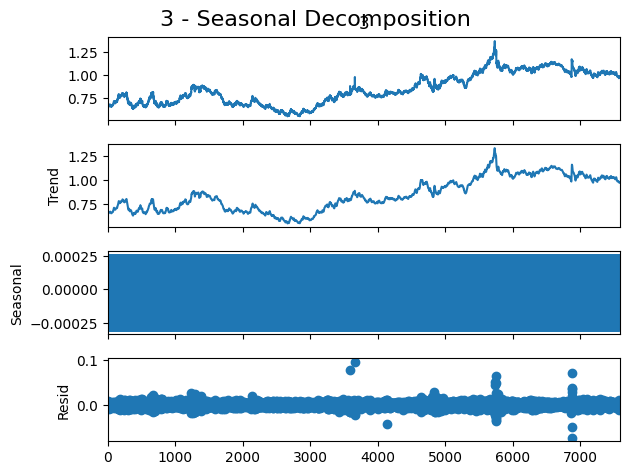

Seasonal decomposition for 4


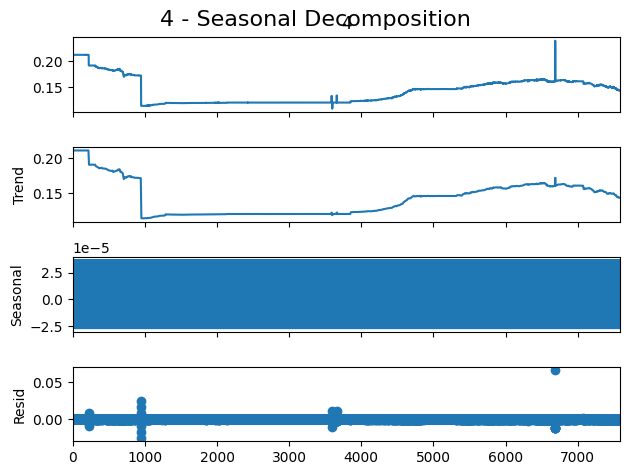

Seasonal decomposition for 5


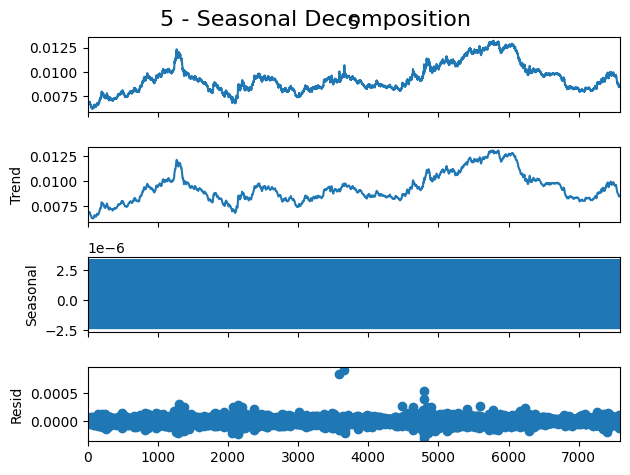

Seasonal decomposition for 6


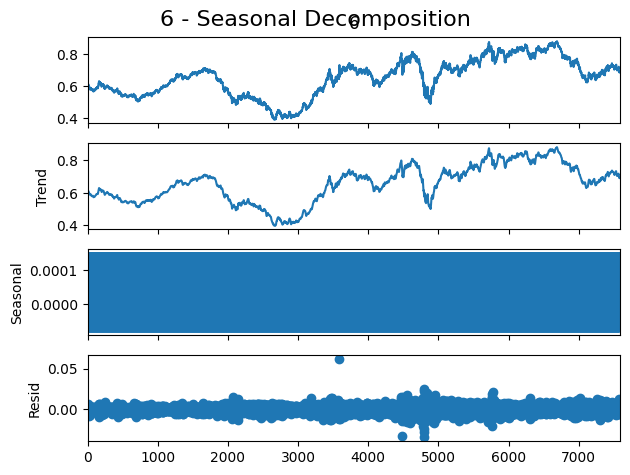

Seasonal decomposition for 7


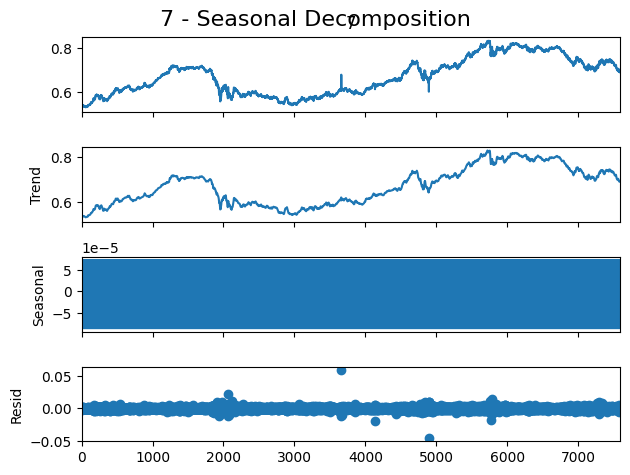

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Example: rolling window of 7 days (weekly)
rolling_window = 7

# Compute rolling mean and std for all currencies
rolling_mean = df.rolling(window=rolling_window).mean()
rolling_std = df.rolling(window=rolling_window).std()

# Plot rolling statistics for each currency
plt.figure(figsize=(15, 8))
for col in df.columns:
    plt.plot(df[col], label=f"{col} Original")
    plt.plot(rolling_mean[col], linestyle='--', label=f"{col} Rolling Mean")
plt.title(f"Exchange Rates with {rolling_window}-Day Rolling Mean")
plt.xlabel("Days")
plt.ylabel("Exchange Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal decomposition for all currencies (adjust period as needed, e.g., 7 for weekly, 30 for monthly)
for col in df.columns:
    print(f"Seasonal decomposition for {col}")
    result = seasonal_decompose(df[col], model='additive', period=rolling_window)
    result.plot()
    plt.suptitle(f"{col} - Seasonal Decomposition", fontsize=16)
    plt.show()


# Preprocess

In [ ]:
df.head()

,0,1,2,3,4,5,6,7
0,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
2,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
3,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
4,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [ ]:
# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled = df.copy()

In [ ]:
split_ratio = 0.8
split_idx = int(len(df_scaled) * split_ratio)
df_train = df_scaled.iloc[:split_idx]
df_test = df_scaled.iloc[split_idx:]

In [ ]:
window_size = 168
forecast_horizon = 24   # 24 days = 24
batch_size = 8
n_nodes=df_train.shape[1]

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size)
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size)

# Model: BiLSTM Stack

In [ ]:
@register_keras_serializable()
class LSTM_Model(tf.keras.Model):
    def __init__(self, n_nodes, hidden_dim=128, horizon=24, dropout_rate=0.2, bi=True, n_stack=1, norm=True, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_stack = n_stack
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.norm = norm
        self.norm1 = tf.keras.layers.LayerNormalization()

        if bi:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
          else:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
          self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
        else:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)
          else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
          self.lstm2 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.norm :
          x = self.norm1(x)
        for i in range(self.n_stack - 1):
          x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return tf.reshape(x, (-1, self.horizon, self.n_nodes))




In [ ]:
n_nodes = df_train.shape[1]
hidden_dim = 32
forecast_horizon = 24

model = LSTM_Model(
                    n_nodes = n_nodes,
                    hidden_dim = hidden_dim,
                    horizon = forecast_horizon,
                    dropout_rate = 0.1,
                    bi = True,
                    n_stack=1,
                    norm=True,
                  )

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'lstm__model_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


    735/Unknown 14s 16ms/step - loss: 0.0853 - mae: 0.1122

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


735/735 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0852 - mae: 0.1121 - val_loss: 0.0152 - val_mae: 0.0860
Epoch 2/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0039 - mae: 0.0329 - val_loss: 0.0145 - val_mae: 0.0830
Epoch 3/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0038 - mae: 0.0323 - val_loss: 0.0135 - val_mae: 0.0789
Epoch 4/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0038 - mae: 0.0317 - val_loss: 0.0130 - val_mae: 0.0763
Epoch 5/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0037 - mae: 0.0312 - val_loss: 0.0128 - val_mae: 0.0752
Epoch 6/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0037 - mae: 0.0309 - val_loss: 0.0129 - val_mae: 0.0750
Epoch 7/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0037 - mae: 0.0307 - val_loss: 0.0132 - val_mae: 0.0755
Epoch 8/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0037 - mae: 0.0305 - val_loss: 0.0136 - val_mae: 0.0763
Epoch 9/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/st

# Patched TalNet: TalNetV2

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TalNetV2(tf.keras.Model):
    def __init__(self, n_nodes, horizon, n_heads=4, hidden_dim=128, dropout_rate=0.1,
                 bi=False, n_stack=1, en_norm=False, node_emb_dim=16, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.en_norm = en_norm
        self.node_emb_dim = node_emb_dim

        self.node_embedding = tf.keras.layers.Embedding(input_dim=n_nodes, output_dim=node_emb_dim)
        self.norm = tf.keras.layers.LayerNormalization()
        self.temporal_conv = tf.keras.layers.Conv1D(
                                                    filters=hidden_dim, kernel_size=3,
                                                    padding='causal', activation='relu'
                                                    )

        if bi:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
            self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False))
            self.d_model = hidden_dim * 2
        else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
            self.lstm2 = tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False)
            self.d_model = hidden_dim

        self.transformer_blocks = []
        for _ in range(n_stack):
            self.transformer_blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=self.d_model),
                "attn_add": tf.keras.layers.Add(),
                "attn_norm": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(2 * self.d_model, activation='relu'),
                    tf.keras.layers.Dense(self.d_model),
                ]),
                "ffn_add": tf.keras.layers.Add(),
                "ffn_norm": tf.keras.layers.LayerNormalization()
            })

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.en_norm:
            x = self.norm(x)

        batch_size = tf.shape(x)[0]
        time_steps = tf.shape(x)[1]

        node_ids = tf.range(self.n_nodes)
        node_emb = self.node_embedding(node_ids)
        node_emb_exp = tf.expand_dims(node_emb, 0)
        node_emb_exp = tf.expand_dims(node_emb_exp, 0)
        node_emb_tiled = tf.tile(node_emb_exp, [batch_size, time_steps, 1, 1])

        x_exp = tf.expand_dims(x, -1)
        x_concat = tf.concat([x_exp, node_emb_tiled], axis=-1)

        x_reshaped = tf.reshape(x_concat, [batch_size * self.n_nodes, time_steps, 1 + self.node_emb_dim])
        x_conv = self.temporal_conv(x_reshaped)
        x_conv_reshaped = tf.reshape(x_conv, [batch_size, time_steps, self.n_nodes, self.hidden_dim])
        x_for_lstm = tf.reshape(x_conv_reshaped, [batch_size, time_steps, self.n_nodes * self.hidden_dim])

        x_lstm1 = self.lstm1(x_for_lstm)

        x = x_lstm1
        for block in self.transformer_blocks:
            attn_out = block["attn"](x, x, x)
            x = block["attn_add"]([x, attn_out])
            x = block["attn_norm"](x)

            ffn_out = block["ffn"](x)
            x = block["ffn_add"]([x, ffn_out])
            x = block["ffn_norm"](x)

        x_lstm2 = self.lstm2(x)
        x_drop = self.dropout(x_lstm2)
        x_out = self.fc(x_drop)
        out = tf.reshape(x_out, [batch_size, self.horizon, self.n_nodes])

        return out

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "hidden_dim": self.hidden_dim,
            "horizon": self.horizon,
            "dropout_rate":self.dropout_rate,
            "bi" : self.bi,
            "n_stack":self.n_stack,
            "norm": self.norm
        })
        return config


In [ ]:
model = TalNetV2(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    n_heads=1,
    hidden_dim=32,
    dropout_rate=0.1,
    bi=False,
    n_stack=2,
    en_norm=False,
    node_emb_dim=8
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'tal_net_v2_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


    733/Unknown 26s 24ms/step - loss: 0.1256 - mae: 0.1534

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


735/735 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.1253 - mae: 0.1530 - val_loss: 0.0135 - val_mae: 0.0763
Epoch 2/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0040 - mae: 0.0320 - val_loss: 0.0132 - val_mae: 0.0751
Epoch 3/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0038 - mae: 0.0310 - val_loss: 0.0129 - val_mae: 0.0741
Epoch 4/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0037 - mae: 0.0306 - val_loss: 0.0128 - val_mae: 0.0736
Epoch 5/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0037 - mae: 0.0304 - val_loss: 0.0127 - val_mae: 0.0735
Epoch 6/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0037 - mae: 0.0304 - val_loss: 0.0127 - val_mae: 0.0736
Epoch 7/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0037 - mae: 0.0304 - val_loss: 0.0129 - val_mae: 0.0743
Epoch 8/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0039 - mae: 0.0319 - val_loss: 0.0127 - val_mae: 0.0735
Epoch 9/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/st

# Evaluation

In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }

In [ ]:
# Collect y_test from the test_dataset
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)


In [ ]:
y_pred = model.predict(test_dataset)

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [ ]:
print(f'Model Name: Stacked BiLSTM')
for step in [3, 6, 12, 24]:
    rse, corr = step_rse_corr(y_test, y_pred, step)
    print(f"Step {str(step):3s}--> RSE={rse:.4f}, CORR={corr:.4f}")

Model Name: Stacked BiLSTM
Step 3  --> RSE=0.2425, CORR=0.9789
Step 6  --> RSE=0.2447, CORR=0.9787
Step 12 --> RSE=0.2460, CORR=0.9786
Step 24 --> RSE=0.2510, CORR=0.9780


In [ ]:
print(f'Model Name: Stacked BiLSTM')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: Stacked BiLSTM
Step  3 --> R²=0.9412, RMSE=0.1101, MAE=0.0723, MSE=0.0121, SMAPE=18.80%, RSE=0.2425, CORR=0.9789
Step  6 --> R²=0.9401, RMSE=0.1111, MAE=0.0732, MSE=0.0123, SMAPE=19.64%, RSE=0.2447, CORR=0.9787
Step 12 --> R²=0.9395, RMSE=0.1116, MAE=0.0736, MSE=0.0125, SMAPE=17.61%, RSE=0.2460, CORR=0.9786
Step 24 --> R²=0.9370, RMSE=0.1138, MAE=0.0750, MSE=0.0129, SMAPE=16.18%, RSE=0.2510, CORR=0.9780


In [ ]:
print(f'Model Name: TelNetV2')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: TelNetV2
Step  3 --> R²=0.9429, RMSE=0.1085, MAE=0.0701, MSE=0.0118, SMAPE=11.87%, RSE=0.2390, CORR=0.9791
Step  6 --> R²=0.9423, RMSE=0.1090, MAE=0.0705, MSE=0.0119, SMAPE=11.92%, RSE=0.2401, CORR=0.9790
Step 12 --> R²=0.9410, RMSE=0.1102, MAE=0.0714, MSE=0.0121, SMAPE=12.07%, RSE=0.2429, CORR=0.9787
Step 24 --> R²=0.9381, RMSE=0.1128, MAE=0.0735, MSE=0.0127, SMAPE=12.29%, RSE=0.2488, CORR=0.9782


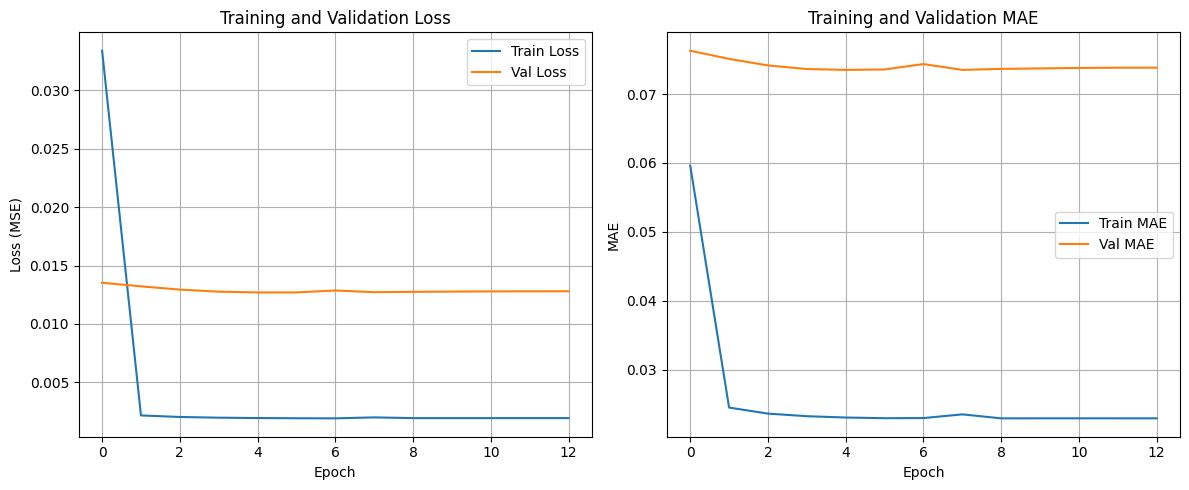

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# model.save('/content/drive/MyDrive/data/varsity/exchange_biLSTM.keras')

In [ ]:
model.save('/content/drive/MyDrive/data/varsity/TalNetV2_exchange.keras')

In [ ]:
# model = load_model(
#     '/content/drive/MyDrive/data/varsity/TalNetV2_exchange.keras',
#     custom_objects={'TalNetV2': TalNetV2}
# )

In [ ]:
# from tensorflow.keras.models import load_model

# # 1. Dummy init that keeps keras internals intact
# def dummy_init(self, *args, **kwargs):
#     super(TalNetV2, self).__init__()

# # 2. Monkey patch the class
# original_init = TalNetV2.__init__
# TalNetV2.__init__ = dummy_init

# # 3. Load the model
# model = load_model('/content/drive/MyDrive/data/varsity/TalNetV2_solar.keras', custom_objects={"TalNetV2": TalNetV2})

# # 4. Restore original init
# TalNetV2.__init__ = original_init
